In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')
with open('/srv/scratch/z5297792/Clim_data/Sample_Data/dic_sample_vert_info.pkl', 'rb') as f:
    dic_sample = pickle.load(f)

sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


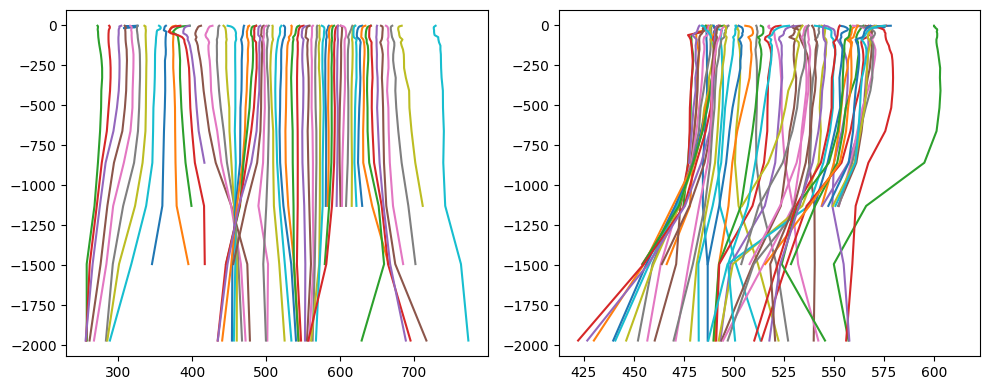

In [3]:
eddy = 382
dic = dic_sample[f'Eddy{eddy}']
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for day in dic.keys():
    df = dic[day].copy()
    df = df[df['Depth'] >= -2000]
    axs[0].plot(df['x'], df['Depth'])
    axs[1].plot(df['y'], df['Depth'])
plt.tight_layout()


### Delta Appraoch to Tilt

In [4]:
eddy   = 8
dic    = dic_sample[f'Eddy{eddy}']
num    = 6
depth_int = 10
max_depth = 1000

diffs_x = {}
diffs_y = {}

df_int = pd.DataFrame(columns=['Day', 'Depth', 'x', 'y'])

for d, day in enumerate(dic.keys()):
    if d >= num:
        break

    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    depths       = df.index.values
    # interpolate at every 10 m from 0 to max_depth
    target_depths = np.arange(0, max_depth+1, depth_int)
    valid = target_depths[
        (target_depths >= depths.min()) &
        (target_depths <= depths.max())
    ]
    if len(valid) < 2:
        continue

    x_i = np.interp(valid, depths, df['x'].values)
    y_i = np.interp(valid, depths, df['y'].values)

    dx = np.diff(x_i)
    dy = np.diff(y_i)

    delta = np.hypot(dx, dy)

    # use the actual depth levels (valid[:-1]) as the Series index
    idx = valid[:-1]

    diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
    diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

    df = pd.DataFrame({'Day': day[3:], 'Depth': valid, 'x': x_i, 'y': y_i})

    if d == 0:
        df_int = df
    else:
        df_int = pd.concat([df_int, df], ignore_index=True)

# now construct your DataFrames simply by passing the dict-of-series:
df_X = pd.DataFrame(diffs_x)
df_Y = pd.DataFrame(diffs_y)

# each df_X, df_Y will be indexed by the **union** of all depth-levels,
# with NaNs where a particular day didn’t have that depth.
df_X

,$t_{0}$,$t_{1}$,$t_{2}$,$t_{3}$,$t_{4}$,$t_{5}$
10,-0.840735,-0.367667,0.551057,-1.533649,1.140657,-0.821091
20,0.959572,0.330551,0.639500,-1.629964,-0.380991,-0.175243
30,2.933629,0.997133,-0.264428,-0.139964,-0.671661,-0.438691
40,1.293718,0.368873,-0.386111,0.128967,-0.788902,-0.704685
50,0.053931,-0.785330,-0.068554,2.222622,0.204992,-0.470692
...,...,...,...,...,...,...
800,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
810,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
820,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434
830,0.118188,0.279145,0.342366,0.260017,0.181393,0.139434


In [14]:
# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\Delta x$'] = df_X.mean(axis=1)
df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data


,$\Delta x$,$\Delta y$,$\sum{\Delta x}$,$\sum{\Delta y}$,$\sigma^2_{\Delta x}$,$\sigma^2_{\Delta y}$,Total $\sigma^2$,weight,Depth
10,-0.311905,-0.660437,-0.311905,-0.660437,0.988872,1.258006,2.246879,0.445062,10
20,-0.042763,-0.573812,-0.354667,-1.234249,0.923112,1.349159,2.272271,0.440088,20
30,0.402670,-0.556531,0.048002,-1.790780,1.368261,1.647341,3.015602,0.331609,30
40,-0.014690,-0.050613,0.033313,-1.841392,0.786529,0.930366,1.716895,0.582447,40
50,0.192828,0.102945,0.226141,-1.738447,1.058761,1.038788,2.097549,0.476747,50
...,...,...,...,...,...,...,...,...,...
800,0.220091,-0.212043,11.089141,-9.557524,0.087658,0.170880,0.258538,3.867905,800
810,0.220091,-0.212043,11.309231,-9.769567,0.087658,0.170880,0.258538,3.867905,810
820,0.220091,-0.212043,11.529322,-9.981610,0.087658,0.170880,0.258538,3.867905,820
830,0.220091,-0.212043,11.749413,-10.193654,0.087658,0.170880,0.258538,3.867905,830
